In [1]:
from collections import OrderedDict
import cvxpy as cp
import datetime as dt
from loguru import logger
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import typing as t


In [2]:
from quantified_strategies.event_trading import russell_rebalance, super_bowl
from quantified_strategies.overnight_trading import short_term_reversal
from quantified_strategies.seasonal_trading import (
    buy_when_yields_are_low, pay_day_strategy, santa_claus_strategy, september_bear, tax_day_strategy, turn_around_tuesday_strategy)
from quantified_strategies.technical_trading import contrarian_trading

from quantified_strategies import strategy_utils

May need to change to fit other strategy


In [3]:
def get_available(start: dt.date, end: dt.date) -> pd.DataFrame:

    availability_event_trading = pd.concat([
        russell_rebalance.avb.get_availability(start=start, end=end).to_frame(name="russell_rebalance"),
        super_bowl.avb.get_availability(start=start, end=end).to_frame(name="super_bowl"),
    ], axis=1)
    availability_event_trading.columns = pd.MultiIndex.from_product(
        [["event_trading"], availability_event_trading.columns.tolist()], names=["type", "name"])
    
    availability_overnight_trading = pd.concat([
        short_term_reversal.avb.get_availability(start=start, end=end).to_frame(name="short_term_reversal"),
    ], axis=1)
    availability_overnight_trading.columns = pd.MultiIndex.from_product(
        [["overnight_trading"], availability_overnight_trading.columns.tolist()], names=["type", "name"])
    
    availability_seasonal_trading = pd.concat([
        buy_when_yields_are_low.avb.get_availability(start=start, end=end).to_frame(name="buy_when_yields_are_low"),
        pay_day_strategy.avb.get_availability(start=start, end=end).to_frame(name="pay_day_strategy"),
        santa_claus_strategy.santa_claus.avb.get_availability(start=start, end=end).to_frame(name="santa_claus_strategy"),
        santa_claus_strategy.sankt_nikolaus.avb.get_availability(start=start, end=end).to_frame(name="sankt_nikolaus_strategy"),
        september_bear.avb.get_availability(start=start, end=end).to_frame(name="september_bear"),
        tax_day_strategy.avb.get_availability(start=start, end=end).to_frame(name="tax_day_strategy"),
        turn_around_tuesday_strategy.avb.get_availability(start=start, end=end).to_frame(name="turn_around_tuesday_strategy"),
    ], axis=1)
    availability_seasonal_trading.columns = pd.MultiIndex.from_product(
        [["seasonal_trading"], availability_seasonal_trading.columns.tolist()], names=["type", "name"])
    
    availability_technical_trading = pd.concat([
        contrarian_trading.avb.get_availability(start=start, end=end).to_frame(name="contrarian_trading"),
    ], axis=1)
    availability_technical_trading.columns = pd.MultiIndex.from_product(
        [["technical_trading"], availability_technical_trading.columns.tolist()], names=["type", "name"])

    availability = pd.concat([
        availability_event_trading, availability_overnight_trading, availability_seasonal_trading, availability_technical_trading,
    ], axis=1)
    availability = availability.sort_index()

    return availability


def get_base_trading(strategy_map: t.Dict[str, str | t.List[str]], start: dt.date, end: dt.date) -> pd.DataFrame:

    def convert_df(dfs: t.List[pd.DataFrame], name: str) -> pd.DataFrame:
        df = pd.concat(dfs, axis=1)

        columns = make_multi_index(
            type=[name], 
            name=list(OrderedDict.fromkeys(df.columns.get_level_values("name"))), 
            ticker=list(OrderedDict.fromkeys(df.columns.get_level_values("ticker"))),
        )
        columns = pd.MultiIndex.from_tuples([tuple(col) for col in columns if col[1:] in df.columns.tolist()])
        df.columns = columns
        
        return df

    def make_multi_index(**kwargs) -> pd.MultiIndex:
        return pd.MultiIndex.from_product(
            [args if isinstance(args, t.List) else [args] for _, args in kwargs.items()], 
            names=[kw for kw in kwargs.keys()]
        )
    

    strategy_map_list = {strat: [universe] if isinstance(universe, str) else universe for strat, universe in strategy_map.items()}
    
    # Define Event Trading
    returns_event_trading = []
    for rr_ticker in strategy_map_list.get("russell_rebalance", []):
        df = russell_rebalance.utils.run(ticker=rr_ticker, start=start, end=end).to_frame(name="russell_rebalance")
        df.columns = make_multi_index(name="russell_rebalance", ticker=rr_ticker)
        returns_event_trading.append(df)
    for sb_ticker in strategy_map_list.get("super_bowl", []):
        df = super_bowl.utils.run(ticker=sb_ticker, start=start, end=end).to_frame(name="super_bowl")
        df.columns = make_multi_index(name="super_bowl", ticker=sb_ticker)
        returns_event_trading.append(df)
    returns_event_trading = convert_df(dfs=returns_event_trading, name="event_trading")

    # Define Overnight Trading
    returns_overnight_trading = []
    for str_ticker in strategy_map_list.get("short_term_reversal", []):
        df = short_term_reversal.utils.run(ticker=str_ticker, start=start, end=end).to_frame(name="short_term_reversal")
        df.columns = make_multi_index(name="short_term_reversal", ticker=str_ticker)
        returns_overnight_trading.append(df)
    returns_overnight_trading = convert_df(dfs=returns_overnight_trading, name="overnight_trading")

    # Define Seasonal Trading
    returns_seasonal_trading = []
    ## Global Activity i.e. trigger is NOT auto
    for bwyl_ticker in strategy_map_list.get("buy_when_yields_are_low", []):
        df = buy_when_yields_are_low.utils.run(ticker=bwyl_ticker, start=start, end=end, asset_day_after=TRADED_DAY_AFTER.get(bwyl_ticker, False)).to_frame(name="buy_when_yields_are_low")
        df.columns = make_multi_index(name="buy_when_yields_are_low", ticker=bwyl_ticker)
        returns_seasonal_trading.append(df)
    for pd_ticker in strategy_map_list.get("pay_day_strategy", []):
        df= pay_day_strategy.utils.run(ticker=pd_ticker, start=start, end=end).to_frame(name="pay_day_strategy")
        df.columns = make_multi_index(name="pay_day_strategy", ticker=pd_ticker)
        returns_seasonal_trading.append(df)
    # TODO: Define European ETFs
    for sn_ticker in strategy_map_list.get("sankt_nikolaus_strategy", []):
        df = santa_claus_strategy.sankt_nikolaus.utils.run(ticker=sn_ticker, start=start, end=end).to_frame(name="sankt_nikolaus_strategy")
        df.columns = make_multi_index(name="sankt_nikolaus_strategy", ticker=sn_ticker)
        returns_seasonal_trading.append(df)
    for sc_ticker in strategy_map_list.get("santa_claus_strategy", []):
        df = santa_claus_strategy.santa_claus.utils.run(ticker=sc_ticker, start=start, end=end, close_on_nth_day_in_new_year=5).to_frame(name="santa_claus_strategy")
        df.columns = make_multi_index(name="santa_claus_strategy", ticker=sc_ticker)
        returns_seasonal_trading.append(df)
    for sb_ticker in strategy_map_list.get("september_bear", []):
        df = september_bear.utils.run(ticker=sb_ticker, start=start, end=end, xday=4, week_enter=3, cover_duration=1).to_frame(name="september_bear")
        df.columns = make_multi_index(name="september_bear", ticker=sb_ticker)
        returns_seasonal_trading.append(df)
    for td_ticker in strategy_map_list.get("tax_day_strategy", []):
        df = tax_day_strategy.utils.run(ticker=td_ticker, start=start, end=end, enter_before=dict(month=3, day=31), exit_after=dict(month=4, day=15)).to_frame(name="tax_day_strategy")
        df.columns = make_multi_index(name="tax_day_strategy", ticker=td_ticker)
        returns_seasonal_trading.append(df)
    ## Auto-Activity i.e. trigger is correlated to ticker
    for tat_ticker in strategy_map_list.get("turn_around_tuesday_strategy", []):
        df = turn_around_tuesday_strategy.utils.run(ticker=tat_ticker, start=start, end=end).to_frame(name="turn_around_tuesday_strategy")
        df.columns = make_multi_index(name="turn_around_tuesday_strategy", ticker=tat_ticker)
        returns_seasonal_trading.append(df)
    # returns_seasonal_trading["turn_around_tuesday(QQQ)"] = turn_around_tuesday_strategy.utils.run(ticker="QQQ", start=start, end=end)
    returns_seasonal_trading = convert_df(dfs=returns_seasonal_trading, name="seasonal_trading")

    returns_df = pd.concat([returns_event_trading, returns_overnight_trading, returns_seasonal_trading], axis=1)
    returns_df = returns_df.sort_index()

    return returns_df
        

In [4]:

def get_change_dataframe(data: pd.DataFrame, start: dt.date) -> pd.DataFrame:
    
    dfs = []
    for i, columns in enumerate(data.columns):
    
        ticker = None
        if len(columns) == 2:
            _, strat_name = columns
        elif len(columns) == 3:
            _, strat_name, ticker = columns

        logger.info(f"Getting changes in {strat_name = !r}")
        
        a = data.iloc[:, i].fillna(False)
        changes = a[a.diff().fillna(1) != 0.0]
    
        df = pd.DataFrame({"start": changes.index, "end": changes.index[1:].tolist() + [a.index[-1]], "value": changes.values})
        df = df.loc[df["value"] != 0.0]
        df["strategy"] = strat_name
        if ticker is not None:
            df["asset"] = ticker
        df["days_to_start"] = (df["start"] - start).dt.days
        df["days_completed"] = (df["end"].clip(upper=pd.Timestamp(dt.date.today())) - start).dt.days
        df["days_to_end"] = (df["end"] - start).dt.days
        df["task_duration"] = df["days_to_end"] - df["days_to_start"] + 1  # to include also the end date
        df["completion_days"] = df["task_duration"] * (df["days_completed"] - df["days_to_start"]) / (df["days_to_end"] - df["days_to_start"])
        dfs.append(df)
    
    df = pd.concat(dfs, axis=0)
    df = df.reset_index(drop=True)

    return df

def plot(availability: pd.DataFrame, activity: pd.DataFrame = None, 
         change_availability: pd.DataFrame = None, change_activity: pd.DataFrame = None) -> None:

    def plot_dataframe(actual: pd.DataFrame, change: pd.DataFrame, color: str):
        change = get_change_dataframe(data=actual, start=availability.index[0]) if change is None else change
        
        ax.barh(
            y=change["strategy"], 
            width=change["task_duration"], 
            left=change["days_to_start"],
            color=color,
            alpha=0.2,
        )

        ax.barh(
            y=change["strategy"], 
            width=change["completion_days"], 
            left=change["days_to_start"],
            color=color,
        )
        return

    def format_plot():
        
        plt.gca().invert_yaxis()

        # Fetch all indices
        list_of_indices = availability.index.tolist()
        today_index = list_of_indices.index(pd.Timestamp(dt.date.today()))
        ax.axvline(x=today_index, color="red", linestyle="--")
        ax.text(x=today_index + 0.5, y=availability.shape[1] - 1 + 0.33, s=f"{dt.date.today():%d-%m}", color="r")
        
        # Get indices you want to show
        x_tick_labels = pd.date_range(start=list_of_indices[0], end=list_of_indices[-1], freq="YS")
        # Get index of each date in labels
        x_ticks = [list_of_indices.index(label) for label in x_tick_labels]
        ax.set_xticks(x_ticks)
        ax.set_xticklabels([date.date() for date in x_tick_labels])

        ax.xaxis.grid(True, alpha=0.5)
        
        plt.title("Strategy Calendar", fontsize=15)
        plt.legend(handles=[matplotlib.patches.Patch(color=color) for _, color in color_map.items()], 
                   labels=color_map.keys(), fontsize=11, bbox_to_anchor=(1.1, 1.05))

        return

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    color_map = {"available": colors[0], "active": colors[1]}

    fig, ax = plt.subplots(figsize=(15, 7))

    plot_dataframe(actual=availability, change=change_availability, color=color_map["available"])
    if activity is not None:
        plot_dataframe(actual=activity, change=change_activity, color=color_map["active"])
    else:
        del color_map["active"]
    format_plot()

    plt.show()

    return




## Portfolio Optimization

### Define Start and End Date for Portfolio

In [5]:
START_DATE = dt.date(2010, 1, 1)
END_DATE = dt.date.today()

### Define Strategy Universe

In [6]:
US_INDICES = ["SPY.US", "QQQ.US"]
US_INDICES = ["SPY.US", "QQQ.US", "XLC.US", "XLE.US", "XLF.US", "XLI.US", "XLK.US", "XLP.US", "XLRE.US", "XLU.US", "XLY.US", "XLV.US"]
TRADED_DAY_AFTER = {asset: False for asset in US_INDICES}

# US_INDICES = ["VUSA.LSE", "CNX1.LSE"] 
# TRADED_DAY_AFTER = {asset: True for asset in US_INDICES}

strategy_universe_map = {
    # "russell_rebalance": "IWM",
    # "sankt_nikolaus_strategy": "EWG",
    "super_bowl": US_INDICES,
    "short_term_reversal": US_INDICES,
    "buy_when_yields_are_low": US_INDICES,
    "pay_day_strategy": US_INDICES,
    "santa_claus_strategy": US_INDICES,
    "september_bear": US_INDICES,
    "tax_day_strategy": US_INDICES,
    "turn_around_tuesday_strategy": US_INDICES,
}
strategy_universe_map

{'super_bowl': ['SPY.US',
  'QQQ.US',
  'XLC.US',
  'XLE.US',
  'XLF.US',
  'XLI.US',
  'XLK.US',
  'XLP.US',
  'XLRE.US',
  'XLU.US',
  'XLY.US',
  'XLV.US'],
 'short_term_reversal': ['SPY.US',
  'QQQ.US',
  'XLC.US',
  'XLE.US',
  'XLF.US',
  'XLI.US',
  'XLK.US',
  'XLP.US',
  'XLRE.US',
  'XLU.US',
  'XLY.US',
  'XLV.US'],
 'buy_when_yields_are_low': ['SPY.US',
  'QQQ.US',
  'XLC.US',
  'XLE.US',
  'XLF.US',
  'XLI.US',
  'XLK.US',
  'XLP.US',
  'XLRE.US',
  'XLU.US',
  'XLY.US',
  'XLV.US'],
 'pay_day_strategy': ['SPY.US',
  'QQQ.US',
  'XLC.US',
  'XLE.US',
  'XLF.US',
  'XLI.US',
  'XLK.US',
  'XLP.US',
  'XLRE.US',
  'XLU.US',
  'XLY.US',
  'XLV.US'],
 'santa_claus_strategy': ['SPY.US',
  'QQQ.US',
  'XLC.US',
  'XLE.US',
  'XLF.US',
  'XLI.US',
  'XLK.US',
  'XLP.US',
  'XLRE.US',
  'XLU.US',
  'XLY.US',
  'XLV.US'],
 'september_bear': ['SPY.US',
  'QQQ.US',
  'XLC.US',
  'XLE.US',
  'XLF.US',
  'XLI.US',
  'XLK.US',
  'XLP.US',
  'XLRE.US',
  'XLU.US',
  'XLY.US',
  'XLV.US']

### Get when Strategies are possible to trade

In [7]:
availability = get_available(start=START_DATE, end=END_DATE)
availability.head(5)

type           event_trading              overnight_trading  \
name       russell_rebalance super_bowl short_term_reversal   
2010-01-01             False      False                True   
2010-01-02             False      False                True   
2010-01-03             False      False                True   
2010-01-04             False      False                True   
2010-01-05             False      False                True   

type              seasonal_trading                                        \
name       buy_when_yields_are_low pay_day_strategy santa_claus_strategy   
2010-01-01                    True             True                 True   
2010-01-02                    True             True                 True   
2010-01-03                    True             True                 True   
2010-01-04                    True             True                 True   
2010-01-05                    True             True                 True   

type                                                                \
name       sankt_nikolaus_strategy september_bear tax_day_strategy   
2010-01-01                   False          False            False   
2010-01-02                   False          False            False   
2010-01-03                   False          False            False   
2010-01-04                   False          False            False   
2010-01-05                   False          False            False   

type                                     technical_trading  
name       turn_around_tuesday_strategy contrarian_trading  
2010-01-01                         True               True  
2010-01-02                         True               True  
2010-01-03                         True               True  
2010-01-04                         True               True  
2010-01-05                         True               True

### Get returns from trading each strategy

In [8]:
base_returns_df = get_base_trading(strategy_map=strategy_universe_map, start=START_DATE, end=END_DATE)
base_returns_df = base_returns_df.sort_index()
base_returns_df.head(5)

{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api from here
{}
remove api fr

event_trading                                                   \
              super_bowl                                                    
                  SPY.US QQQ.US XLC.US XLE.US XLF.US XLI.US XLK.US XLP.US   
Date                                                                        
2010-01-04           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-05           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-06           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-07           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-08           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                           ...             seasonal_trading                \
                           ... turn_around_tuesday_strategy                 
           XLRE.US XLU.US  ...                       XLC.US XLE.US XLF.US   
Date                       ...                                              
2010-01-04     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-05     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-06     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-07     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-08     NaN    NaN  ...                          NaN    NaN    NaN   

                                                              
                                                              
           XLI.US XLK.US XLP.US XLRE.US XLU.US XLY.US XLV.US  
Date                                                          
2010-01-04    NaN    NaN    NaN     NaN    NaN    NaN    NaN  
2010-01-05    NaN    NaN    NaN     NaN    NaN    NaN    NaN  
2010-01-06    NaN    NaN    NaN     NaN    NaN    NaN    NaN  
2010-01-07    NaN    NaN    NaN     NaN    NaN    NaN    NaN  
2010-01-08    NaN    NaN    NaN     NaN    NaN    NaN    NaN  

[5 rows x 96 columns]

In [29]:
base_returns_df

event_trading                                                   \
              super_bowl                                                    
                  SPY.US QQQ.US XLC.US XLE.US XLF.US XLI.US XLK.US XLP.US   
Date                                                                        
2010-01-04           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-05           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-06           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-07           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-08           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2024-02-28           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-02-29           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-03-01           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-03-04           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-03-05           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                           ...             seasonal_trading                \
                           ... turn_around_tuesday_strategy                 
           XLRE.US XLU.US  ...                       XLC.US XLE.US XLF.US   
Date                       ...                                              
2010-01-04     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-05     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-06     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-07     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-08     NaN    NaN  ...                          NaN    NaN    NaN   
...            ...    ...  ...                          ...    ...    ...   
2024-02-28     NaN    NaN  ...                     0.008899    NaN    NaN   
2024-02-29     NaN    NaN  ...                          NaN    NaN    NaN   
2024-03-01     NaN    NaN  ...                          NaN    NaN    NaN   
2024-03-04     NaN    NaN  ...                          NaN    NaN    NaN   
2024-03-05     NaN    NaN  ...                          NaN    NaN    NaN   

                                                                 
                                                                 
           XLI.US XLK.US XLP.US XLRE.US XLU.US XLY.US    XLV.US  
Date                                                             
2010-01-04    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-05    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-06    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-07    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-08    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
...           ...    ...    ...     ...    ...    ...       ...  
2024-02-28    NaN    NaN    NaN     NaN    NaN    NaN  -0.00815  
2024-02-29    NaN    NaN    NaN     NaN    NaN    NaN  0.010496  
2024-03-01    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2024-03-04    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2024-03-05    NaN    NaN    NaN     NaN    NaN    NaN       NaN  

[3566 rows x 96 columns]

### Get when Strategies are actively trading

In [30]:
activity = ~base_returns_df.isna()
activity.head(5)

event_trading                                                   \
              super_bowl                                                    
                  SPY.US QQQ.US XLC.US XLE.US XLF.US XLI.US XLK.US XLP.US   
Date                                                                        
2010-01-04         False  False  False  False  False  False  False  False   
2010-01-05         False  False  False  False  False  False  False  False   
2010-01-06         False  False  False  False  False  False  False  False   
2010-01-07         False  False  False  False  False  False  False  False   
2010-01-08         False  False  False  False  False  False  False  False   

                           ...             seasonal_trading                \
                           ... turn_around_tuesday_strategy                 
           XLRE.US XLU.US  ...                       XLC.US XLE.US XLF.US   
Date                       ...                                              
2010-01-04   False  False  ...                        False  False  False   
2010-01-05   False  False  ...                        False  False  False   
2010-01-06   False  False  ...                        False  False  False   
2010-01-07   False  False  ...                        False  False  False   
2010-01-08   False  False  ...                        False  False  False   

                                                              
                                                              
           XLI.US XLK.US XLP.US XLRE.US XLU.US XLY.US XLV.US  
Date                                                          
2010-01-04  False  False  False   False  False  False  False  
2010-01-05  False  False  False   False  False  False  False  
2010-01-06  False  False  False   False  False  False  False  
2010-01-07  False  False  False   False  False  False  False  
2010-01-08  False  False  False   False  False  False  False  

[5 rows x 96 columns]

### Get changes in strategies availability to trade

In [31]:
change_availability = get_change_dataframe(data=availability, start=availability.index[0])
change_availability

2024-03-05 16:03:12.424 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'russell_rebalance'
2024-03-05 16:03:12.450 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:12.463 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'short_term_reversal'
2024-03-05 16:03:12.473 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'buy_when_yields_are_low'
2024-03-05 16:03:12.483 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'pay_day_strategy'
2024-03-05 16:03:12.499 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'santa_claus_strategy'
2024-03-05 16:03:12.523 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'sankt_nikolaus_strategy'
2024-03-05 16:03:12.543 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'september_bear'
20

,start,end,value,strategy,days_to_start,days_completed,days_to_end,task_duration,completion_days
0,2010-06-23,2010-07-02,True,russell_rebalance,173,182,182,10,10.0
1,2011-06-23,2011-07-02,True,russell_rebalance,538,547,547,10,10.0
2,2012-06-23,2012-07-03,True,russell_rebalance,904,914,914,11,11.0
3,2013-06-23,2013-07-02,True,russell_rebalance,1269,1278,1278,10,10.0
4,2014-06-23,2014-07-02,True,russell_rebalance,1634,1643,1643,10,10.0
...,...,...,...,...,...,...,...,...,...
256,2021-03-31,2021-04-15,True,tax_day_strategy,4107,4122,4122,16,16.0
257,2022-03-31,2022-04-18,True,tax_day_strategy,4472,4490,4490,19,19.0
258,2023-03-31,2023-04-17,True,tax_day_strategy,4837,4854,4854,18,18.0
259,2010-01-01,2024-03-05,True,turn_around_tuesday_strategy,0,5177,5177,5178,5178.0


### Get changes in strategy activity

In [32]:
change_activity = get_change_dataframe(data=activity, start=availability.index[0])
change_activity

2024-03-05 16:03:15.322 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.337 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.349 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.362 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.372 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.387 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.402 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.413 | INFO     | __main__:get_change_dataframe:12 - Getting changes in strat_name = 'super_bowl'
2024-03-05 16:03:15.424 | INFO     | __main__:get_change_datafra

,start,end,value,strategy,asset,days_to_start,days_completed,days_to_end,task_duration,completion_days
0,2010-02-08,2010-02-23,True,super_bowl,SPY.US,38,53,53,16,16.0
1,2011-02-07,2011-02-22,True,super_bowl,SPY.US,402,417,417,16,16.0
2,2012-02-06,2012-02-21,True,super_bowl,SPY.US,766,781,781,16,16.0
3,2013-02-04,2013-02-19,True,super_bowl,SPY.US,1130,1145,1145,16,16.0
4,2014-02-03,2014-02-18,True,super_bowl,SPY.US,1494,1509,1509,16,16.0
...,...,...,...,...,...,...,...,...,...,...
7468,2023-09-18,2023-09-25,True,turn_around_tuesday_strategy,XLV.US,5008,5015,5015,8,8.0
7469,2023-10-02,2023-10-06,True,turn_around_tuesday_strategy,XLV.US,5022,5026,5026,5,5.0
7470,2023-10-23,2023-10-30,True,turn_around_tuesday_strategy,XLV.US,5043,5050,5050,8,8.0
7471,2023-11-27,2023-11-30,True,turn_around_tuesday_strategy,XLV.US,5078,5081,5081,4,4.0


## Plot availability to trade versus strategy actviity

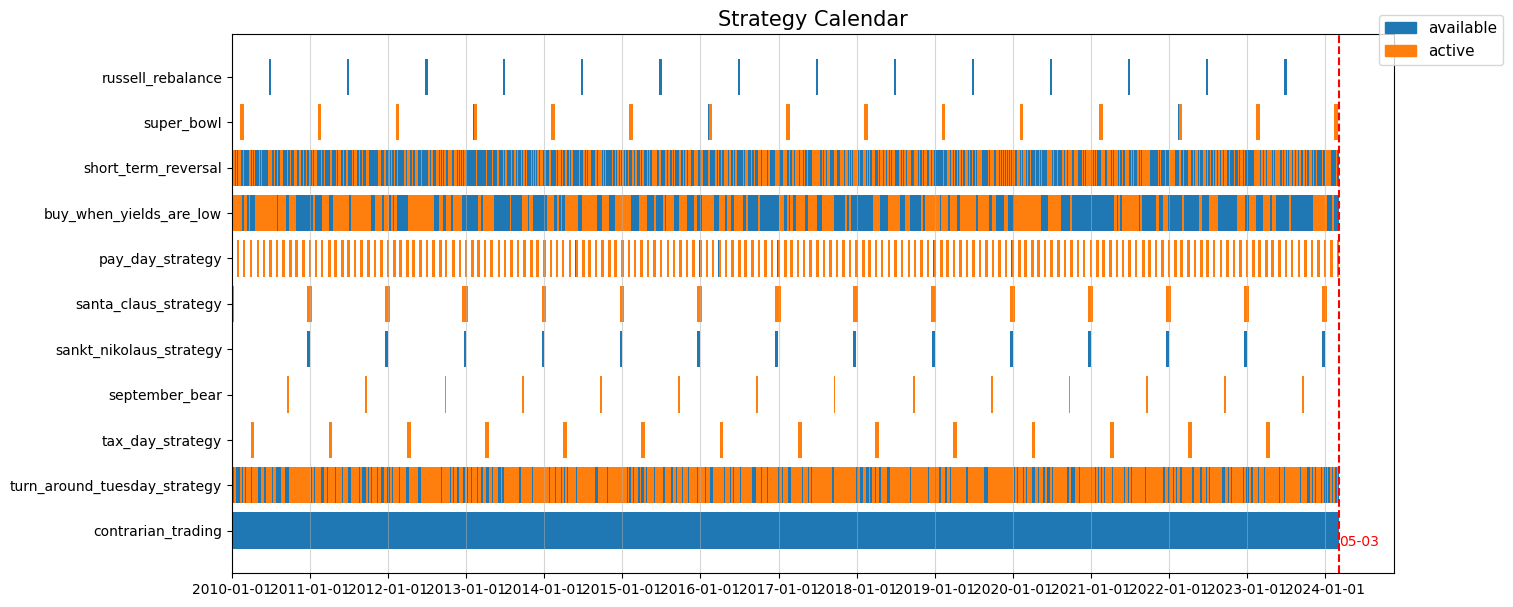

In [33]:
plot(availability=availability, activity=activity, change_availability=change_availability, change_activity=change_activity)

In [34]:
base_returns_df

event_trading                                                   \
              super_bowl                                                    
                  SPY.US QQQ.US XLC.US XLE.US XLF.US XLI.US XLK.US XLP.US   
Date                                                                        
2010-01-04           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-05           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-06           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-07           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-01-08           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2024-02-28           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-02-29           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-03-01           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-03-04           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2024-03-05           NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                           ...             seasonal_trading                \
                           ... turn_around_tuesday_strategy                 
           XLRE.US XLU.US  ...                       XLC.US XLE.US XLF.US   
Date                       ...                                              
2010-01-04     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-05     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-06     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-07     NaN    NaN  ...                          NaN    NaN    NaN   
2010-01-08     NaN    NaN  ...                          NaN    NaN    NaN   
...            ...    ...  ...                          ...    ...    ...   
2024-02-28     NaN    NaN  ...                     0.008899    NaN    NaN   
2024-02-29     NaN    NaN  ...                          NaN    NaN    NaN   
2024-03-01     NaN    NaN  ...                          NaN    NaN    NaN   
2024-03-04     NaN    NaN  ...                          NaN    NaN    NaN   
2024-03-05     NaN    NaN  ...                          NaN    NaN    NaN   

                                                                 
                                                                 
           XLI.US XLK.US XLP.US XLRE.US XLU.US XLY.US    XLV.US  
Date                                                             
2010-01-04    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-05    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-06    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-07    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2010-01-08    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
...           ...    ...    ...     ...    ...    ...       ...  
2024-02-28    NaN    NaN    NaN     NaN    NaN    NaN  -0.00815  
2024-02-29    NaN    NaN    NaN     NaN    NaN    NaN  0.010496  
2024-03-01    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2024-03-04    NaN    NaN    NaN     NaN    NaN    NaN       NaN  
2024-03-05    NaN    NaN    NaN     NaN    NaN    NaN       NaN  

[3566 rows x 96 columns]

In [49]:
base_returns_df.to_csv(f"outputs/strategy_returns_us_sector_american_etfs.csv")

In [50]:
trading_start = dt.date(START_DATE.year+1, START_DATE.month, START_DATE.day)
trade_end = END_DATE
trading_start = dt.date(2010, 1, 1)
# trade_end = dt.date(2010, 1, 1)
trading_dates = pd.date_range(start=trading_start, end=trade_end)
trading_dates = [date for date in trading_dates if date in activity.index]

strategy_returns = dict()
for trade_date in trading_dates:
    
    is_active = activity.loc[trade_date]
    active_strats = is_active[is_active].index.tolist()
    
    if len(active_strats) == 0:
        strategy_returns[trade_date] = None
        continue
    
    df = base_returns_df.loc[:trade_date, active_strats].head(-1)
    # w = strategy_utils.calculate_markowitz_weights(returns_df=df)
    w = pd.Series(1 / len(active_strats), index=active_strats, dtype=float)
    
    strat_ret = (base_returns_df.loc[trade_date, active_strats] * w).sum()
    strategy_returns[trade_date] = strat_ret
    
    
strategy_returns = pd.Series(strategy_returns)
strategy_returns

2010-01-04    0.001377
2010-01-05    0.001623
2010-01-06    0.003893
2010-01-07    0.003469
2010-01-08    0.002042
                ...   
2024-02-28    0.002927
2024-02-29    0.007535
2024-03-01   -0.000693
2024-03-04         NaN
2024-03-05         NaN
Length: 3566, dtype: float64

Asset                       Undefined
Start                      2023-01-03
End                        2024-03-05
Mean Return                  0.09028%
Total Return                   27.77%
Median Return                0.10185%
1st Quartile                -0.38853%
3rd Quartile                 0.59065%
Std Dev Return               0.81994%
CAGR                        8.693 bps
Trade CAGR                     3.563%
Ann. CAGR                     24.479%
Activity Ratio                 95.92%
Number of Trades                    7
Average Hold Period        40.29 Days
Daily Sharpe Ratio             0.1101
Ann. Sharpe Ratio              1.7478
Adj. Ann. Sharpe Ratio         1.7118
Daily Sortino Ratio            0.1741
Ann. Sortino Ratio             2.7645
Adj. Ann. Sortino Ratio        2.7075
Daily Calmar Ratio             3.2518
Hit Ratio                      56.38%
Profit Factor                   1.33x
MDD                            -8.54%
MDD Start                  2023-02-01
MDD Bottom  

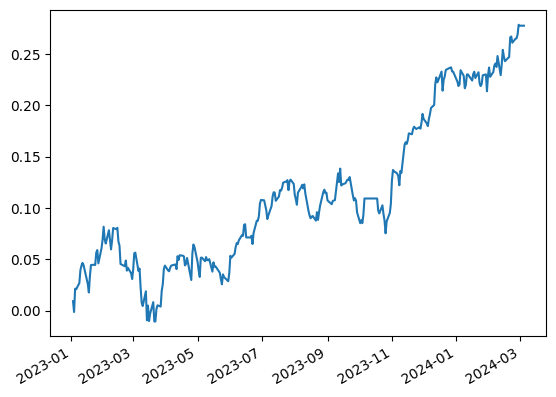

In [51]:
cum_strat_return = strategy_utils.get_cumulative_return(returns=strategy_returns[strategy_returns.index.date >= dt.date(2023, 1, 1)].fillna(0.0), total=False)
cum_strat_return.plot()
strategy_utils.describe(returns=strategy_returns[strategy_returns.index.date >= dt.date(2023, 1, 1)], pos=~(strategy_returns[strategy_returns.index.date >= dt.date(2023, 1, 1)].isna()), daily=True)

<Axes: >

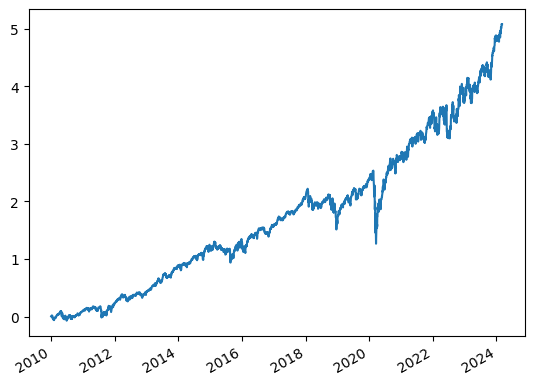

In [52]:
cum_strat_return = strategy_utils.get_cumulative_return(returns=strategy_returns.fillna(0.0), total=False)
cum_strat_return.plot()

In [53]:
strategy_utils.describe(returns=strategy_returns, pos=~(strategy_returns.isna()), daily=True)

Asset                       Undefined
Start                      2010-01-04
End                        2024-03-05
Mean Return                  0.05882%
Total Return                  507.62%
Median Return                0.07426%
1st Quartile                -0.37297%
3rd Quartile                 0.55279%
Std Dev Return               1.07681%
CAGR                        5.301 bps
Trade CAGR                     1.669%
Ann. CAGR                     14.287%
Activity Ratio                 95.49%
Number of Trades                  109
Average Hold Period        31.24 Days
Daily Sharpe Ratio             0.0546
Ann. Sharpe Ratio              0.8672
Adj. Ann. Sharpe Ratio         0.8474
Daily Sortino Ratio            0.0678
Ann. Sortino Ratio             1.0765
Adj. Ann. Sortino Ratio        1.0519
Daily Calmar Ratio             14.133
Hit Ratio                      54.57%
Profit Factor                   1.18x
MDD                           -35.92%
MDD Start                  2020-02-18
MDD Bottom  

In [54]:
data = strategy_utils.get_data(ticker=US_INDICES[0], columns="Adj Close", start=trading_start, end=trade_end)
# data = strategy_utils.get_data(ticker="CNX1.LSE", columns="Adj Close", start=trading_start, end=trade_end)
data

{'start': datetime.date(2010, 1, 1), 'end': datetime.date(2024, 3, 5)}
remove api from here


Date
1993-01-29     24.8363
1993-02-01     25.0130
1993-02-02     25.0660
1993-02-03     25.3309
1993-02-04     25.4369
                ...   
2024-02-27    506.9300
2024-02-28    506.2600
2024-02-29    508.0800
2024-03-01    512.8500
2024-03-04    512.3000
Name: Adj Close, Length: 7829, dtype: float64

In [55]:
ret = data.pct_change().shift(-1)
ret = ret.loc[(ret.index >= strategy_returns.index[0]) & (ret.index <= strategy_returns.index[-1])]
ret

Date
2010-01-04    0.002647
2010-01-05    0.000704
2010-01-06    0.004222
2010-01-07    0.003327
2010-01-08    0.001396
                ...   
2024-02-27   -0.001322
2024-02-28    0.003595
2024-02-29    0.009388
2024-03-01   -0.001072
2024-03-04         NaN
Name: Adj Close, Length: 3565, dtype: float64

Asset                        Undefined
Start                       2023-01-03
End                         2024-03-04
Mean Return                   0.11006%
Total Return                    36.57%
Median Return                 0.07546%
1st Quartile                 -0.37659%
3rd Quartile                  0.63853%
Std Dev Return                0.80994%
CAGR                        10.643 bps
Trade CAGR                     36.570%
Ann. CAGR                      30.742%
Activity Ratio                 100.00%
Number of Trades                   0.0
Average Hold Period        293.00 Days
Daily Sharpe Ratio              0.1359
Ann. Sharpe Ratio               2.1571
Adj. Ann. Sharpe Ratio          2.1571
Daily Sortino Ratio             0.2216
Ann. Sortino Ratio              3.5184
Adj. Ann. Sortino Ratio         3.5184
Daily Calmar Ratio              3.6665
Hit Ratio                       56.31%
Profit Factor                    1.42x
MDD                             -9.97%
MDD Start                

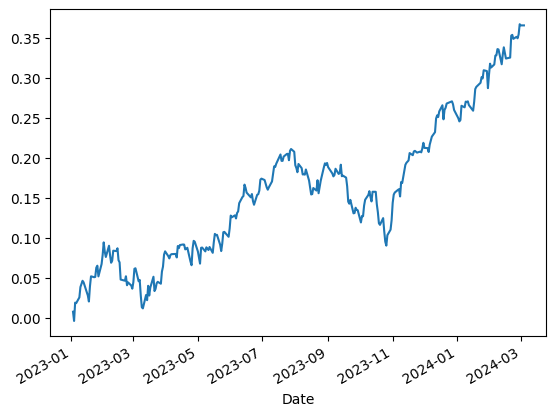

In [63]:
cum_benchmark_return = strategy_utils.get_cumulative_return(returns=ret[ret.index.date >= dt.date(2023, 1, 1)].fillna(0.0), total=False)
cum_benchmark_return.plot()
strategy_utils.describe(returns=ret[ret.index.date >= dt.date(2023, 1, 1)], daily=True)

Asset                          Undefined
Start                         2010-01-04
End                           2024-03-04
Mean Return                     0.05566%
Total Return                     487.98%
Median Return                   0.06585%
1st Quartile                   -0.37397%
3rd Quartile                    0.57944%
Std Dev Return                  1.08782%
CAGR                           4.970 bps
Trade CAGR                      487.979%
Ann. CAGR                        13.340%
Activity Ratio                   100.00%
Number of Trades                     0.0
Average Hold Period        3,565.00 Days
Daily Sharpe Ratio                0.0512
Ann. Sharpe Ratio                 0.8122
Adj. Ann. Sharpe Ratio            0.8122
Daily Sortino Ratio               0.0627
Ann. Sortino Ratio                0.9951
Adj. Ann. Sortino Ratio           0.9951
Daily Calmar Ratio               14.4726
Hit Ratio                         55.12%
Profit Factor                      1.17x
MDD             

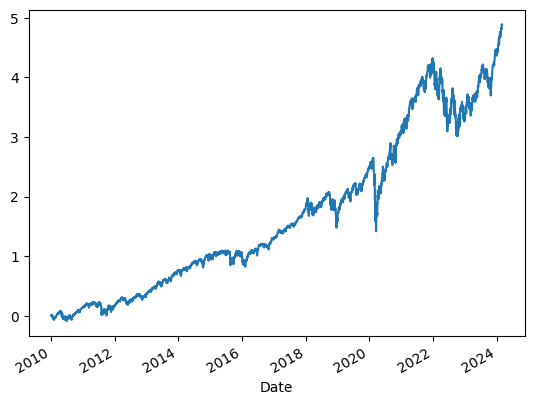

In [64]:
cum_benchmark_return = strategy_utils.get_cumulative_return(returns=ret.fillna(0.0), total=False)
cum_benchmark_return.plot()
strategy_utils.describe(returns=ret, daily=True)

In [59]:
import statsmodels.api as sm

In [60]:
X = sm.add_constant(ret)
y = strategy_returns

In [61]:
X = X.reindex(index=X.index.union(y.index)).fillna(0.0)
y = y.reindex(index=X.index.union(y.index)).fillna(0.0)

In [62]:
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.879
Model:                            OLS   Adj. R-squared (uncentered):              0.879
Method:                 Least Squares   F-statistic:                          1.292e+04
Date:                Tue, 05 Mar 2024   Prob (F-statistic):                        0.00
Time:                        16:05:59   Log-Likelihood:                          14938.
No. Observations:                3566   AIC:                                 -2.987e+04
Df Residuals:                    3564   BIC:                                 -2.986e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.723e-05   6.15e-05      0.930      0.352   -6.34e-05       0.000
Adj Close      0.9069      0.006    160.460      0.000       0.896       0.918
==============================================================================
Omnibus:                     1702.560   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           118583.539
Skew:                           1.423   Prob(JB):                         0.00
Kurtosis:                      31.107   Cond. No.                         92.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""